In [1]:
# Cellule 1 — Imports et chemins

# =========================================================
# Notebook 02 — Split BoneAge with Combined Stratification
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp

BASE_DIR = Path("/home/fabrice/Boneage")
CSV_PATH = BASE_DIR / "boneage-training-dataset-cleaned-v3.csv"

print("Chargement du fichier :", CSV_PATH)
df = pd.read_csv(CSV_PATH)
print("Nombre de lignes :", len(df))
df.head()


Chargement du fichier : /home/fabrice/Boneage/boneage-training-dataset-cleaned-v3.csv
Nombre de lignes : 11325


,id,boneage,male
0,1377,180,False
1,1380,120,True
2,1382,138,True
3,1385,36,True
4,1387,138,True


In [2]:
# Cellule 2 — Création des bins d’âge (18 mois)

# Classes de 18 mois : 0-17, 18-35, ..., 222-239
bins = np.arange(0, 241, 18)
labels = [f"{b}-{b+17}" for b in bins[:-1]]

df["age_bin"] = pd.cut(df["boneage"], bins=bins, labels=labels, right=False)

print("Aperçu des bins :")
df[["boneage", "age_bin"]].head()


Aperçu des bins :


,boneage,age_bin
0,180,180-197
1,120,108-125
2,138,126-143
3,36,36-53
4,138,126-143


In [3]:
# Cellule 3 — Création de la stratification combinée

df["strata"] = df["male"].astype(str) + "_" + df["age_bin"].astype(str)

print("Exemples de strata :")
df["strata"].value_counts().head(10)


Exemples de strata :


strata
True_144-161     1409
True_162-179     1249
False_90-107     1008
False_144-161     971
True_126-143      861
False_126-143     860
True_108-125      676
False_108-125     665
False_72-89       508
True_72-89        472
Name: count, dtype: int64

In [4]:
# Cellule 4 — Split train/test (stratification combinée)

train_df, test_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df["strata"],
    random_state=42
)

print("Taille Train :", len(train_df))
print("Taille Test  :", len(test_df))


Taille Train : 9060
Taille Test  : 2265


In [5]:
# Cellule 5 — Split train_final/val (sur le train uniquement)

train_final_df, val_df = train_test_split(
    train_df,
    test_size=0.15,    # ≈ 12% du dataset total
    stratify=train_df["strata"],
    random_state=42
)

print("Taille Train Final :", len(train_final_df))
print("Taille Validation  :", len(val_df))
print("Taille Test         :", len(test_df))


Taille Train Final : 7701
Taille Validation  : 1359
Taille Test         : 2265


In [6]:
# Cellule 6 — Fonction de comparaison des distributions

def pct_by_bins(temp_df):
    return (temp_df["age_bin"].value_counts(normalize=True)
            .sort_index() * 100)

def compare_age_distributions(df1, df2, name1, name2):
    pct1 = pct_by_bins(df1)
    pct2 = pct_by_bins(df2)
    comp = pd.DataFrame({
        f"{name1}_%" : pct1,
        f"{name2}_%" : pct2,
        "Δ pp" : (pct2 - pct1).round(2)
    })
    print("\n=== Comparaison des distributions d'âge ===")
    print(comp.fillna(0))
    print("Max |Δ| :", comp["Δ pp"].abs().max())


In [7]:
# Cellule 7 — Vérification des distributions sexe + âge

print("\n=== Répartition strata - Train Final ===")
print(train_final_df["strata"].value_counts(normalize=True).head())

print("\n=== Répartition strata - Validation ===")
print(val_df["strata"].value_counts(normalize=True).head())

print("\n=== Répartition strata - Test ===")
print(test_df["strata"].value_counts(normalize=True).head())

# Comparaison par âge
compare_age_distributions(train_final_df, val_df, "TrainFinal", "Val")
compare_age_distributions(train_final_df, test_df, "TrainFinal", "Test")



=== Répartition strata - Train Final ===
strata
True_144-161     0.124399
True_162-179     0.110245
False_90-107     0.088949
False_144-161    0.085703
True_126-143     0.076094
Name: proportion, dtype: float64

=== Répartition strata - Validation ===
strata
True_144-161     0.124356
True_162-179     0.110375
False_90-107     0.089036
False_144-161    0.086093
True_126-143     0.075791
Name: proportion, dtype: float64

=== Répartition strata - Test ===
strata
True_144-161     0.124503
True_162-179     0.110375
False_90-107     0.089183
False_144-161    0.085651
False_126-143    0.075938
Name: proportion, dtype: float64

=== Comparaison des distributions d'âge ===
         TrainFinal_%      Val_%  Δ pp
age_bin                               
0-17         0.181795   0.147167 -0.03
18-35        1.103753   1.103753  0.00
36-53        2.843787   2.869757  0.03
54-71        4.986365   5.003679  0.02
72-89        8.648228   8.682855  0.03
90-107      11.725750  11.699779 -0.03
108-125     11.

In [8]:
# Cellule 8 — Tests statistiques KS sur la variable boneage

def ks_test(a, b, label):
    stat, p = ks_2samp(a, b)
    print(f"{label} — KS stat={stat:.3f}, p-value={p:.4f}")
    if p >= 0.05:
        print(" => Pas de différence significative\n")
    else:
        print(" => Différence significative détectée\n")

print("\n=== KS Tests sur boneage ===")
ks_test(train_final_df["boneage"], val_df["boneage"], "TrainFinal vs Val")
ks_test(train_final_df["boneage"], test_df["boneage"], "TrainFinal vs Test")
ks_test(val_df["boneage"], test_df["boneage"], "Val vs Test")



=== KS Tests sur boneage ===
TrainFinal vs Val — KS stat=0.010, p-value=0.9999
 => Pas de différence significative

TrainFinal vs Test — KS stat=0.006, p-value=1.0000
 => Pas de différence significative

Val vs Test — KS stat=0.010, p-value=1.0000
 => Pas de différence significative



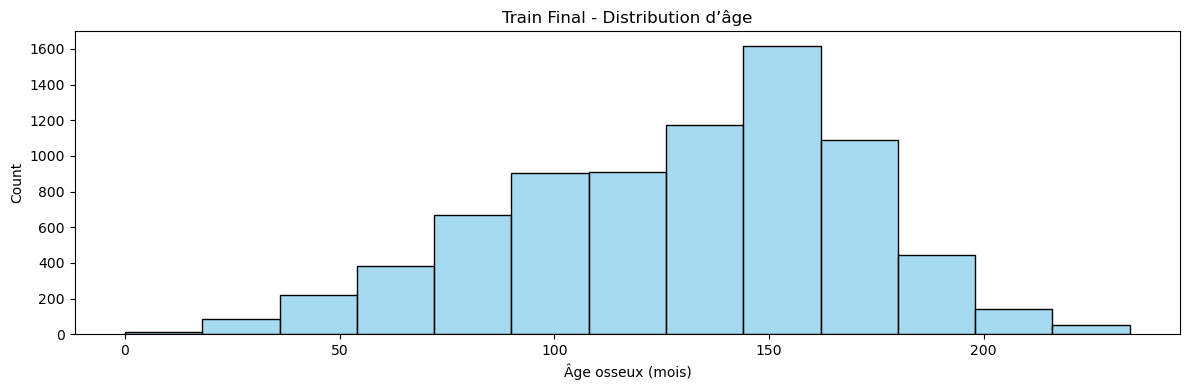

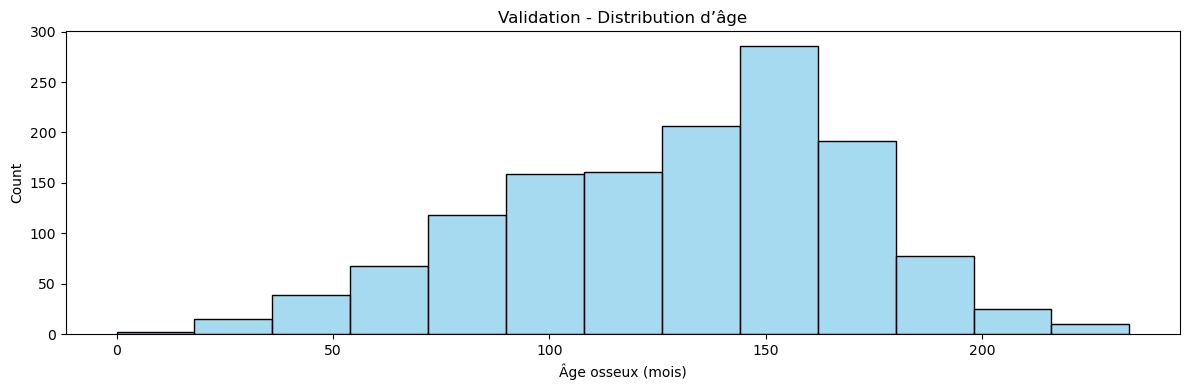

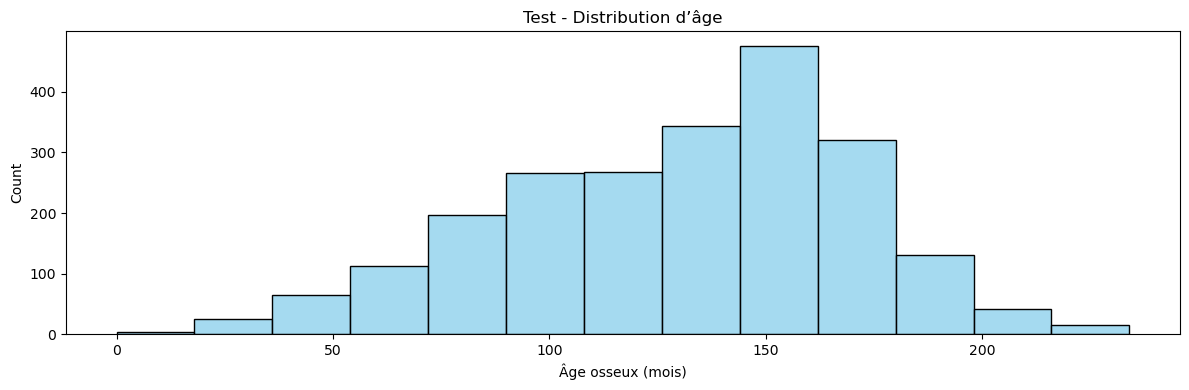

In [9]:
# Cellule 9 — Visualisation rapide

def plot_age_hist(df, title):
    plt.figure(figsize=(12,4))
    sns.histplot(df["boneage"], bins=bins, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Âge osseux (mois)")
    plt.tight_layout()
    plt.show()

plot_age_hist(train_final_df, "Train Final - Distribution d’âge")
plot_age_hist(val_df, "Validation - Distribution d’âge")
plot_age_hist(test_df, "Test - Distribution d’âge")


In [10]:
# Cellule 10 — Sauvegarde des fichiers split

train_path = BASE_DIR / "boneage_train_final_v3.csv"
val_path   = BASE_DIR / "boneage_val_v3.csv"
test_path  = BASE_DIR / "boneage_test_v3.csv"

train_final_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print("Fichiers sauvegardés :")
print(" -", train_path)
print(" -", val_path)
print(" -", test_path)


Fichiers sauvegardés :
 - /home/fabrice/Boneage/boneage_train_final_v3.csv
 - /home/fabrice/Boneage/boneage_val_v3.csv
 - /home/fabrice/Boneage/boneage_test_v3.csv
